<a href="https://colab.research.google.com/github/norhaneng/TASK4_Prodigy_Infotech.ipynb/blob/main/TASK4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data = pd.read_csv('/content/sample_data/twitter_training.csv')
data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [4]:
# data = pd.read_csv("twitter_sentiment_data.csv", header=None)
data.columns = ["Tweet ID", "entity", "sentiment", "Tweet content"]
print(data.head())

   Tweet ID       entity sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                       Tweet content  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...  


In [5]:
data['Tweet content'] = data['Tweet content'].fillna('')  # Replace NaNs with an empty string
data['Tweet content'] = data['Tweet content'].astype(str)  # Ensure all values are strings

In [6]:
# Function to clean tweet text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)     # Remove mentions
    text = re.sub(r"#", "", text)        # Remove hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = text.lower()                  # Convert to lowercase
    return text

# Apply cleaning function
data['clean_text'] = data['Tweet content'].apply(clean_text)


In [10]:
# Using TextBlob to calculate polarity for each tweet (range -1 to 1)
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

data['polarity'] = data['clean_text'].apply(get_sentiment)

# Define sentiment based on polarity score
data['sentiment'] = data['polarity'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))


In [11]:
# Use Latent Dirichlet Allocation (LDA) to identify topics in the tweets.
# Prepare data for topic modeling
stop_words = set(stopwords.words('english'))
data['tokens'] = data['clean_text'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

# Convert tokens into a format suitable for LDA
count_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
count_data = count_vectorizer.fit_transform(data['clean_text'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(count_data)

# Display topics
topics = count_vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    topic_keywords = [topics[i] for i in topic.argsort()[-10:]]
    print(f"Topic {i + 1}: {', '.join(topic_keywords)}")


Topic 1: watch, free, xbox, great, love, win, video, best, just, amazon
Topic 2: dota, world, im, like, warcraft, play, time, rhandlerr, game, overwatch
Topic 3: borderlands, dont, really, xbox, ps5, shit, im, just, game, fuck
Topic 4: fucking, warcraft, awesome, just, overwatch, dota, like, italy, people, game
Topic 5: new, xbox, cold, ops, just, good, war, borderlands, black, like


Visualizations

<ipython-input-12-c4e4b0d44a80>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data['sentiment'], palette="viridis")


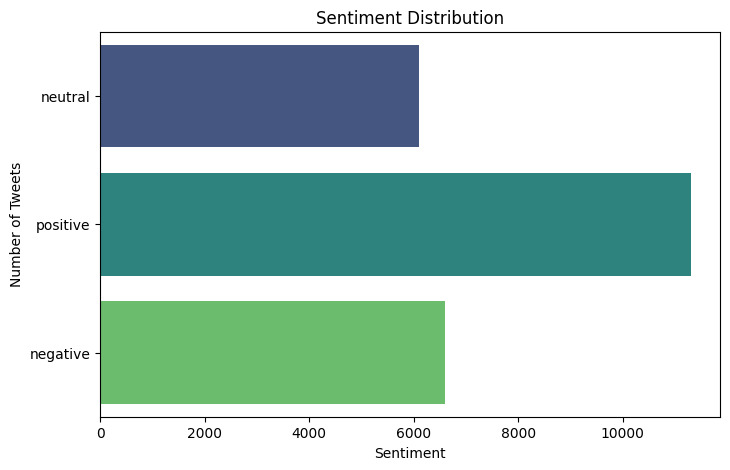

In [12]:
#Sentiment Distribution
# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data['sentiment'], palette="viridis")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()

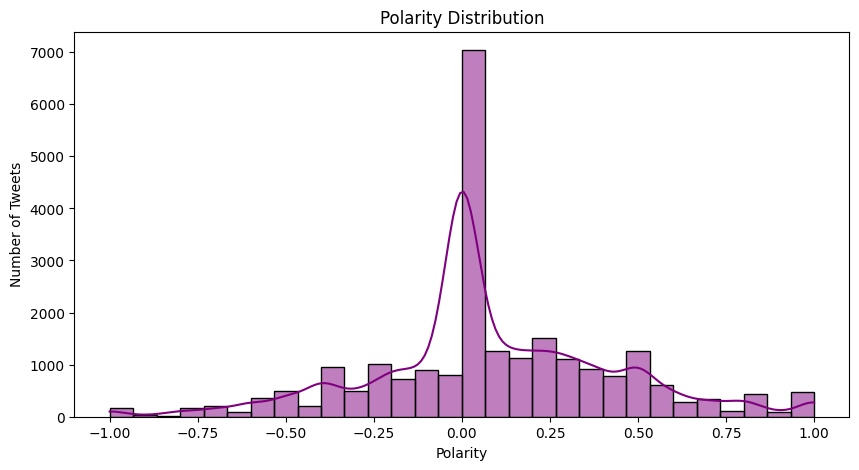

In [13]:
# Plot polarity distribution
plt.figure(figsize=(10, 5))
sns.histplot(data['polarity'], kde=True, bins=30, color="purple")
plt.title("Polarity Distribution")
plt.xlabel("Polarity")
plt.ylabel("Number of Tweets")
plt.show()

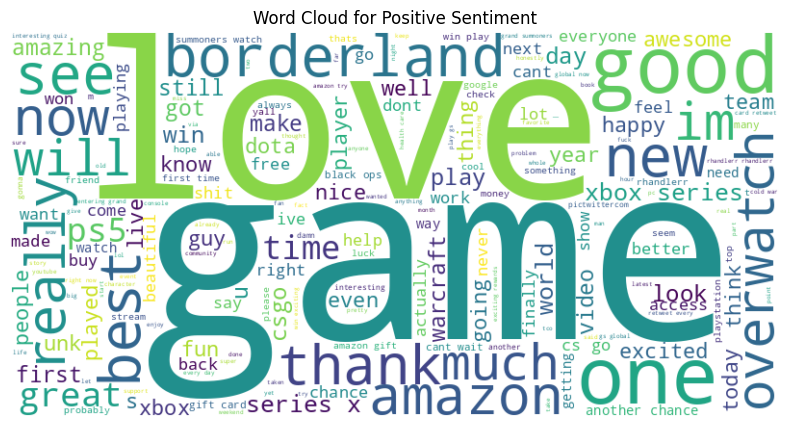

In [14]:
# Word cloud for positive sentiment
positive_words = " ".join([text for text in data[data['sentiment'] == 'positive']['clean_text']])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(positive_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Sentiment")
plt.show()


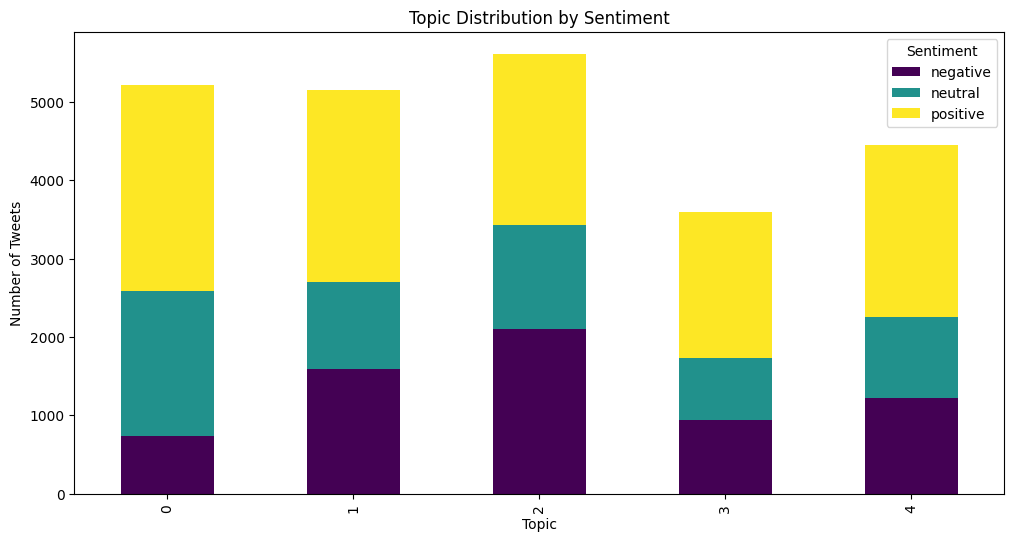

In [16]:
# Adding LDA topic labels back to the dataset
data['topic'] = lda.transform(count_data).argmax(axis=1)

# Plot topic distribution by sentiment
topic_sentiment_dist = data.groupby(['topic', 'sentiment']).size().unstack().fillna(0)
topic_sentiment_dist.plot(kind='bar', stacked=True, figsize=(12, 6), colormap="viridis")
plt.title("Topic Distribution by Sentiment")
plt.xlabel("Topic")
plt.ylabel("Number of Tweets")
plt.legend(title="Sentiment")
plt.show()

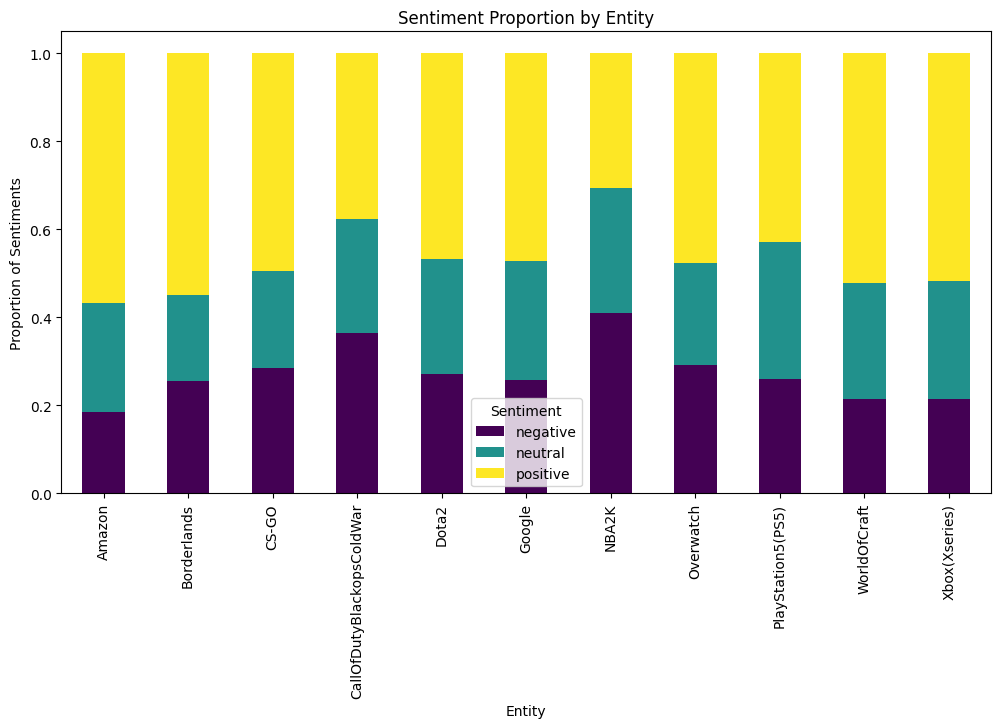

In [19]:
# Sentiment proportions by entity
entity_sentiment = data.groupby(['entity', 'sentiment']).size().unstack(fill_value=0)
entity_sentiment = entity_sentiment.apply(lambda x: x / x.sum(), axis=1)

# Plot
entity_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6), colormap="viridis")
plt.title("Sentiment Proportion by Entity")
plt.xlabel("Entity")
plt.ylabel("Proportion of Sentiments")
plt.legend(title="Sentiment")
plt.show()